<img src="https://github.com/FarzadNekouee/Garbage_Classification_ResNet50_Scratch_to_Transfer-Learning/blob/master/images/Cover_Image_txt.png?raw=true" width="2400">

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Define the path where our dataset is stored
dataset_path = '/kaggle/input/garbage-classification/garbage_classification'

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")
        
        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))
                
# Determine if all images in the entore dataset have the same dimensions 
if len(all_dimensions_set) == 1: 
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

metal folder contains 769 images.
white-glass folder contains 775 images.
biological folder contains 985 images.
paper folder contains 1050 images.
brown-glass folder contains 607 images.
battery folder contains 945 images.
trash folder contains 697 images.
cardboard folder contains 891 images.
shoes folder contains 1977 images.
clothes folder contains 5325 images.
plastic folder contains 865 images.
green-glass folder contains 629 images.

The images in the dataset have different dimensions or color channels.


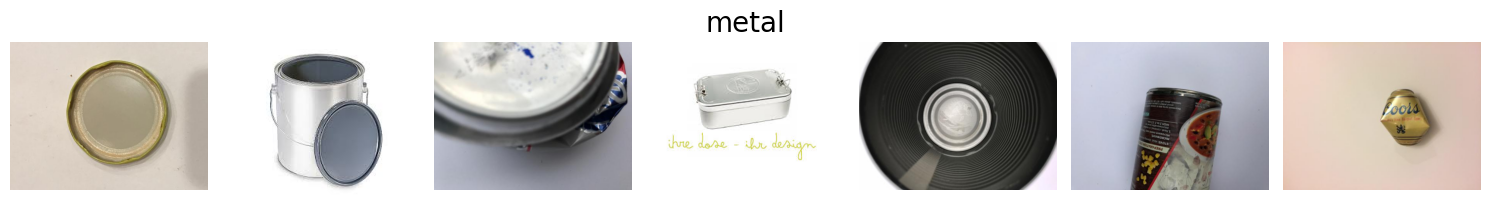

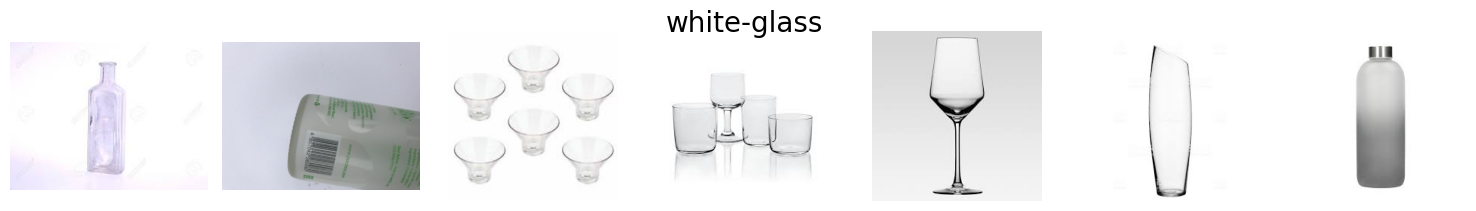

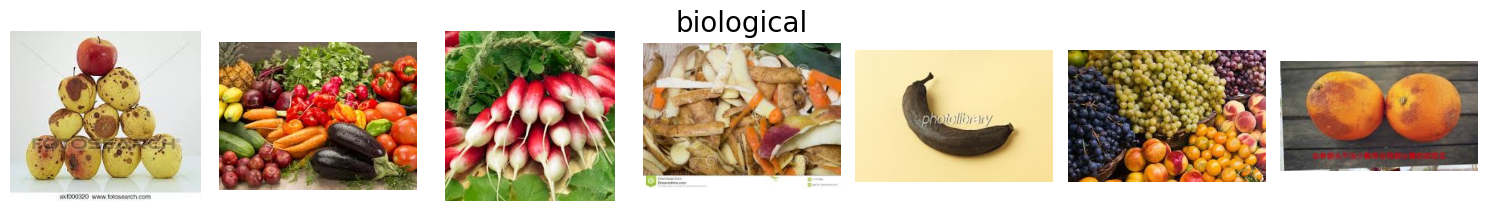

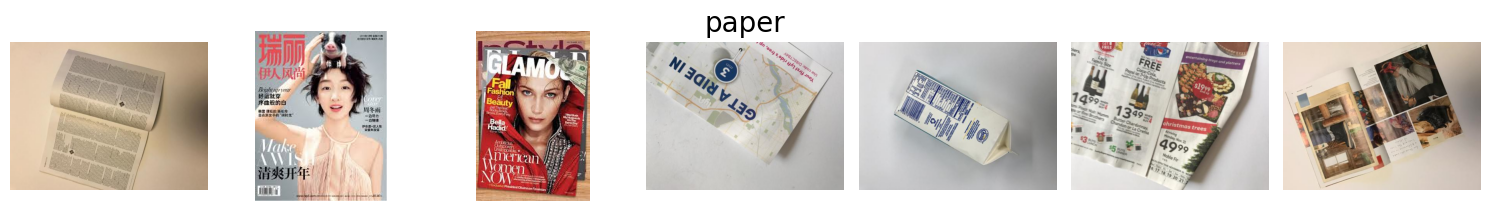

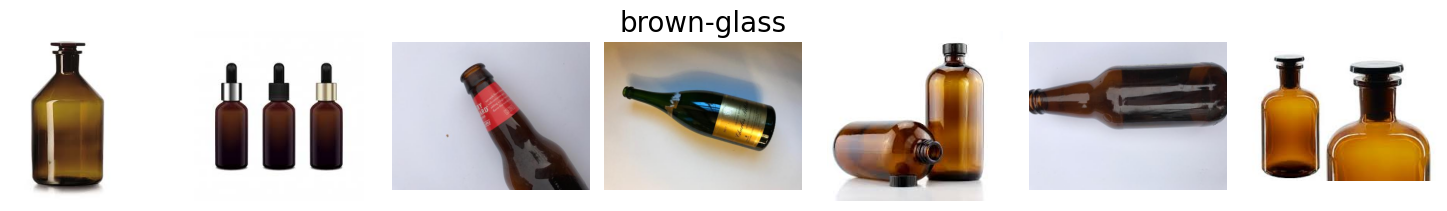

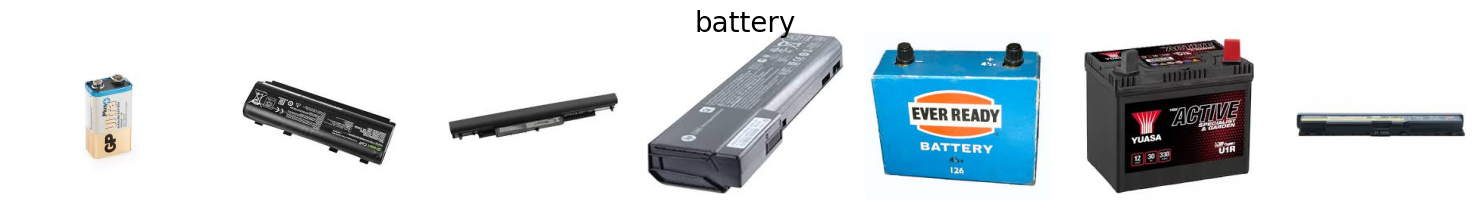

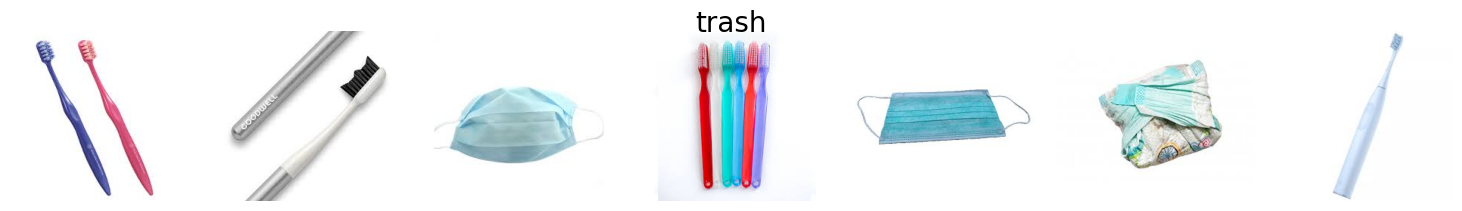

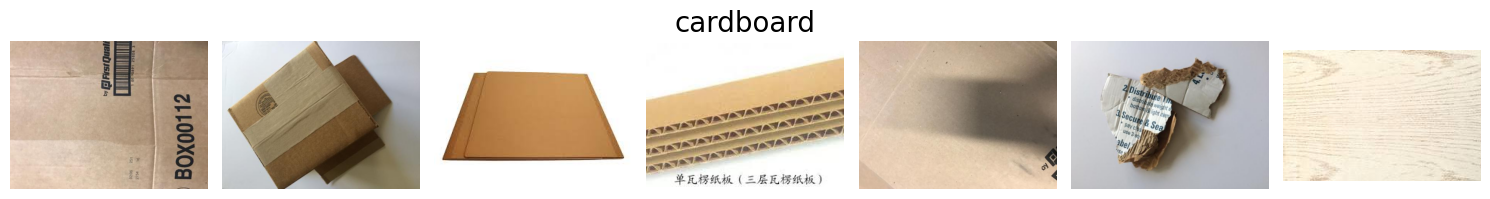

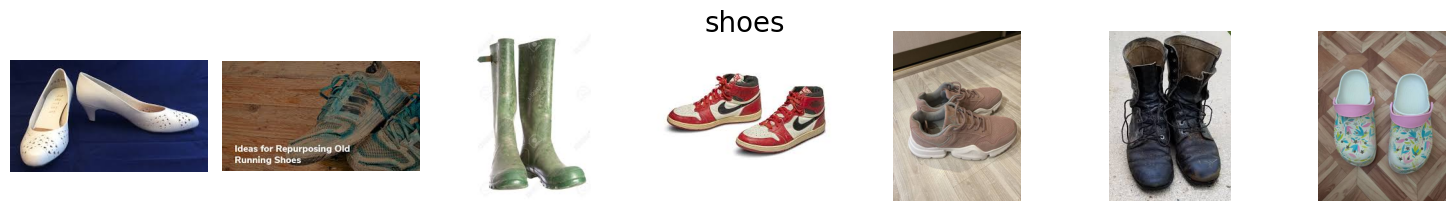

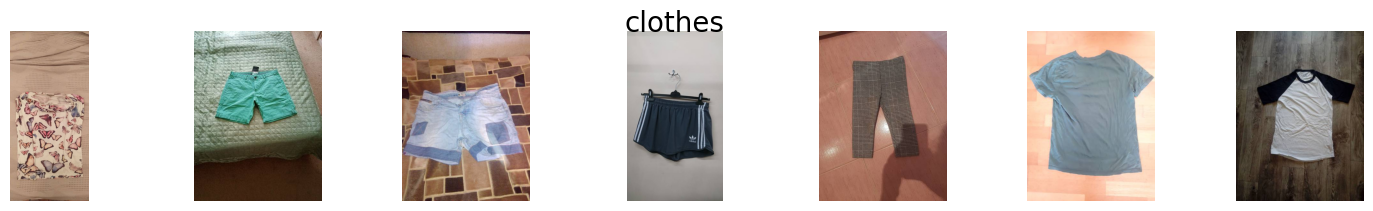

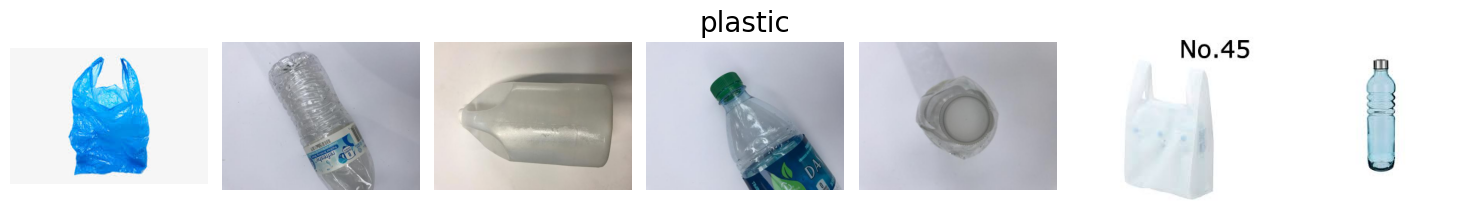

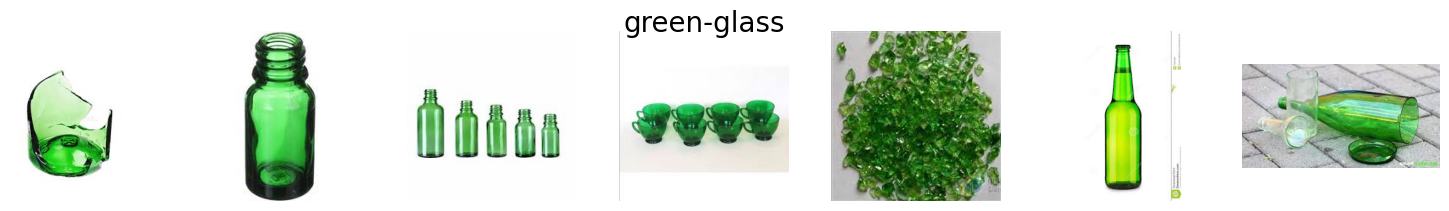

In [3]:
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Select the first 10 images
        image_files = image_files[:7]
        
        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))
        
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')
        
        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

In [4]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    for file in os.listdir(os.path.join(dataset_path, garbage_type)):
        # Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

,filepath,label
0,/kaggle/input/garbage-classification/garbage_c...,metal
1,/kaggle/input/garbage-classification/garbage_c...,metal
2,/kaggle/input/garbage-classification/garbage_c...,metal
3,/kaggle/input/garbage-classification/garbage_c...,metal
4,/kaggle/input/garbage-classification/garbage_c...,metal


In [5]:
# Split with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 12412
Number of images in the validation set: 3103


In [6]:
# 1. Class distribution in the entire dataset
overall_distribution = df['label'].value_counts(normalize=True) * 100

# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
clothes        34.32
shoes          12.74
paper           6.77
biological      6.35
battery         6.09
cardboard       5.74
plastic         5.58
white-glass     5.00
metal           4.96
trash           4.49
green-glass     4.05
brown-glass     3.91
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
clothes        34.32
shoes          12.75
paper           6.77
biological      6.35
battery         6.09
cardboard       5.74
plastic         5.58
white-glass     5.00
metal           4.95
trash           4.50
green-glass     4.05
brown-glass     3.91
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
clothes        34.32
shoes          12.73
paper           6.77
biological      6.35
battery         6.09
cardboard       5.74
plastic         5.58
white-glass     5.00
metal           4.96
trash       

In [7]:
# Extract class labels from the 'label' column of train_df
class_labels = train_df['label'].unique()
class_labels

array(['brown-glass', 'plastic', 'biological', 'white-glass', 'clothes',
       'shoes', 'battery', 'green-glass', 'paper', 'metal', 'cardboard',
       'trash'], dtype=object)

In [9]:
# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
weights

array([2.13264605, 1.49470135, 1.31260575, 1.66827957, 0.24280125,
       0.65381374, 1.36816578, 2.05632869, 1.23134921, 1.68184282,
       1.45067789, 1.85364397])

In [11]:
# Load the ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [12]:
len(base_model.layers) 

175

In [13]:
for i, layer in enumerate(base_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

140 conv4_block6_3_bn
141 conv4_block6_add
142 conv4_block6_out
143 conv5_block1_1_conv
144 conv5_block1_1_bn
145 conv5_block1_1_relu
146 conv5_block1_2_conv
147 conv5_block1_2_bn
148 conv5_block1_2_relu
149 conv5_block1_0_conv
150 conv5_block1_3_conv


In [14]:
# Freeze the layers up to conv4_block6_out
for layer in base_model.layers[:143]: # include the layer 142
    layer.trainable = False

In [25]:
# Create the new model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(12, activation='softmax')(x)

transfer_resnet50_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
transfer_resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rotation_range=60,                  # Randomly rotate the images by up to 60 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.20,                    # Randomly zoom in or out by up to 20%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest',                 # Fill in missing pixels using the nearest filled value
    preprocessing_function=preprocess_input  # Add this line
)

# For the validation set, you might not have augmentation:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Add this line

In [27]:
# Using flow_from_dataframe to generate batches
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 12412 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.


In [28]:
# Convert the computed weights to a dictionary for passing to model training
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: 2.1326460481099656,
 1: 1.4947013487475915,
 2: 1.3126057529610828,
 3: 1.668279569892473,
 4: 0.24280125195618155,
 5: 0.6538137378845343,
 6: 1.3681657848324515,
 7: 2.0563286944996686,
 8: 1.2313492063492064,
 9: 1.6818428184281842,
 10: 1.4506778868630201,
 11: 1.8536439665471924}

In [29]:
print("Assigned Class Weights:")
class_weights

Assigned Class Weights:


{0: 2.1326460481099656,
 1: 1.4947013487475915,
 2: 1.3126057529610828,
 3: 1.668279569892473,
 4: 0.24280125195618155,
 5: 0.6538137378845343,
 6: 1.3681657848324515,
 7: 2.0563286944996686,
 8: 1.2313492063492064,
 9: 1.6818428184281842,
 10: 1.4506778868630201,
 11: 1.8536439665471924}

In [30]:
train_generator.class_indices

{'battery': 0,
 'biological': 1,
 'brown-glass': 2,
 'cardboard': 3,
 'clothes': 4,
 'green-glass': 5,
 'metal': 6,
 'paper': 7,
 'plastic': 8,
 'shoes': 9,
 'trash': 10,
 'white-glass': 11}

In [31]:
# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

# Total number of epochs
num_epochs = 50  

# Train the model
history = transfer_resnet50_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator), 
                                      epochs=num_epochs,
                                      validation_data=val_generator, 
                                      validation_steps=len(val_generator),
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping])

Epoch 1/50
388/388 [==============================] - 505s 1s/step - loss: 0.6099 - accuracy: 0.8360 - val_loss: 0.2836 - val_accuracy: 0.9285 - lr: 1.0000e-04
Epoch 2/50
388/388 [==============================] - 499s 1s/step - loss: 0.2493 - accuracy: 0.9355 - val_loss: 0.2147 - val_accuracy: 0.9439 - lr: 1.0000e-04
Epoch 3/50
388/388 [==============================] - 497s 1s/step - loss: 0.1756 - accuracy: 0.9549 - val_loss: 0.2238 - val_accuracy: 0.9336 - lr: 1.0000e-04
Epoch 4/50
388/388 [==============================] - 498s 1s/step - loss: 0.1257 - accuracy: 0.9645 - val_loss: 0.2331 - val_accuracy: 0.9513 - lr: 1.0000e-04
Epoch 5/50
388/388 [==============================] - 513s 1s/step - loss: 0.1073 - accuracy: 0.9677 - val_loss: 0.2694 - val_accuracy: 0.9381 - lr: 1.0000e-04
Epoch 6/50
388/388 [==============================] - 514s 1s/step - loss: 0.0904 - accuracy: 0.9741 - val_loss: 0.1809 - val_accuracy: 0.9568 - lr: 1.0000e-04
Epoch 7/50
388/388 [====================

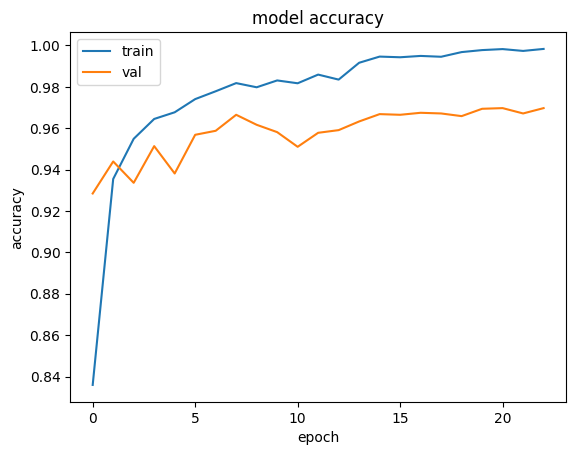

In [34]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

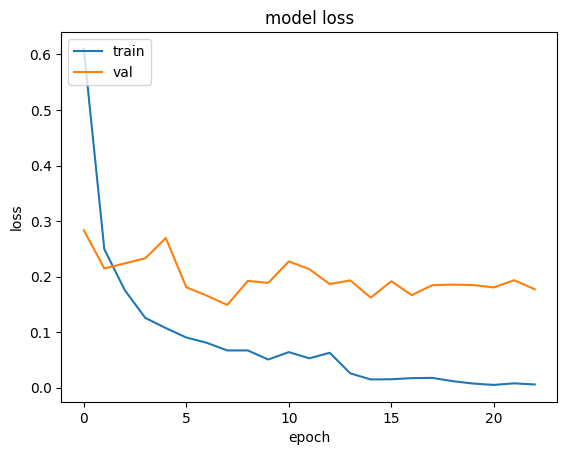

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
test_loss, test_acc = transfer_resnet50_model.evaluate(val_generator, steps=len(val_generator))
print('test accuracy:',test_acc )
print('test loss:',test_loss)

97/97 [==============================] - 24s 242ms/step - loss: 0.1491 - accuracy: 0.9665
test accuracy: 0.9664840698242188
test loss: 0.14906162023544312


In [38]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np

In [47]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
# Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

97/97 [==============================] - 22s 230ms/step
              precision    recall  f1-score   support

     battery       0.95      0.99      0.97       189
  biological       0.99      0.98      0.99       197
 brown-glass       1.00      0.93      0.96       122
   cardboard       1.00      0.94      0.97       178
     clothes       1.00      0.98      0.99      1065
 green-glass       0.96      0.98      0.97       126
       metal       0.94      0.90      0.92       154
       paper       0.96      0.98      0.97       210
     plastic       0.90      0.87      0.89       173
       shoes       0.95      0.98      0.97       395
       trash       0.97      0.96      0.97       139
 white-glass       0.85      0.97      0.91       155

    accuracy                           0.97      3103
   macro avg       0.96      0.96      0.96      3103
weighted avg       0.97      0.97      0.97      3103





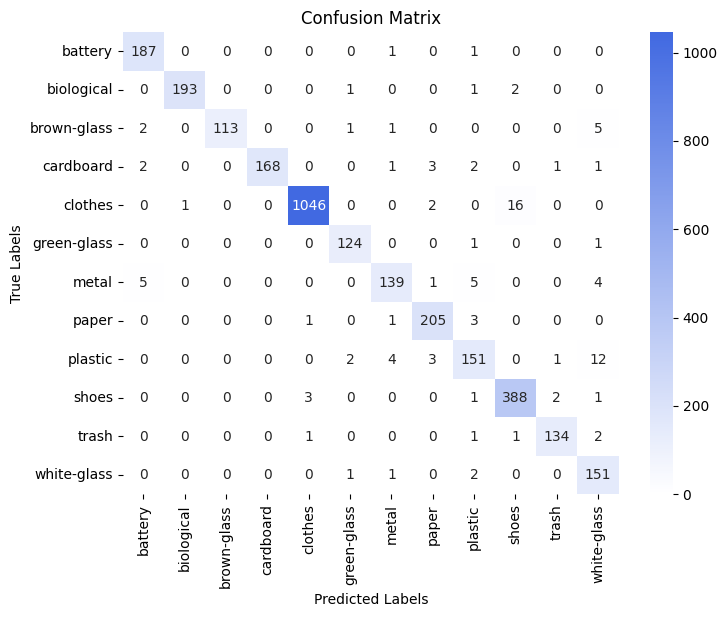

In [48]:
evaluate_model_performance(transfer_resnet50_model, val_generator, class_labels)

In [50]:
transfer_resnet50_model.save('model_resnet_50.h5')